<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/main/two4two_sickones_explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pathlib
import os
from pathlib import Path
import random
import datetime

import numpy as np
from PIL import Image

from skimage.transform import resize

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.default_rng(seed=42)

# Params

In [22]:
load_checkpoints = True

modeltype = 'mobilenet'

biased_ds = None
nobias_ds = 'sick_ones_bendbias'

epochs = 10
learning_rate = 0.0001

# Setup and Load Datasets

In [23]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

def load_data_gens(trainval_datadir, test_datadir):
  train_df = load_dataframe(trainval_datadir, 'train')
  valid_df = load_dataframe(trainval_datadir, 'validation')
  test_df = load_dataframe(test_datadir, 'test')

  datagen = ImageDataGenerator(rescale=1./255)
  train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=trainval_datadir / 'train', target_size=(128, 128),
                                                x_col='filename', y_col='ill', batch_size=64, shuffle=True)
  valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, directory=trainval_datadir / 'validation', target_size=(128, 128),
                                                x_col='filename', y_col='ill', batch_size=64, shuffle=False)
  test_generator = datagen.flow_from_dataframe(dataframe=test_df, directory=test_datadir / 'test',  target_size=(128, 128),
                                               x_col='filename', y_col='ill',
                                               batch_size=64, shuffle=False)

  return train_generator, valid_generator, test_generator

In [24]:
gdrive = Path('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive')
relative_model_path = "two4two_sickones_models"
base_path = gdrive / relative_model_path

output = gdrive / 'hcxai' / 'blocky_diagnosis'

base_path

PosixPath('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/two4two_sickones_models')

In [25]:
data_dir_sickones = keras.utils.get_file(
    origin = "file:///Users/djohnson/sciebo/1. Research/1. HCXAI/1. Projects/two4two_datasets/two4two_datasets.tar.gz",
    fname = 'two4two_datasets.tar.gz',
    extract = True,
    archive_format = 'tar'
)
data_dir_sickones = Path(data_dir_sickones)

## Load Biased and Unbiased datasets

In [26]:
nobias_dir = data_dir_sickones.with_suffix('').with_suffix('') / nobias_ds
biased_dir = data_dir_sickones.with_suffix('').with_suffix('') / biased_ds if biased_ds is not None else None

nobias_dir, biased_dir

(PosixPath('/Users/djohnson/.keras/datasets/two4two_datasets/sick_ones_bendbias'),
 None)

In [27]:
nobias_model_path = base_path / nobias_ds / f'{modeltype}'
biased_model_path = base_path / biased_ds / f'{modeltype}' if biased_ds is not None else None

nobias_model_path, biased_model_path

(PosixPath('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/two4two_sickones_models/sick_ones_bendbias/mobilenet'),
 None)

In [28]:
nobias_model_exists = os.path.exists(nobias_model_path)
biased_model_exists = os.path.exists(biased_model_path) if biased_ds is not None else False

nobias_model_exists, biased_model_exists

(True, False)

In [29]:
# Load Dataframes
nobias_train_df,  nobias_valid_df, nobias_test_df = (load_dataframe(nobias_dir, 'train'),
                                                     load_dataframe(nobias_dir, 'validation'),
                                                     load_dataframe(nobias_dir, 'test'))
nobias_train_df['sphere_diff'] = np.abs(nobias_train_df['spherical'] - nobias_train_df['ill_spherical'])
nobias_valid_df['sphere_diff'] = np.abs(nobias_valid_df['spherical'] - nobias_valid_df['ill_spherical'])
nobias_test_df['sphere_diff'] = np.abs(nobias_test_df['spherical'] - nobias_test_df['ill_spherical'])

if biased_ds is not None:
    biased_train_df,  biased_valid_df, biased_test_df = (load_dataframe(biased_dir, 'train'),
                                                        load_dataframe(biased_dir, 'validation'),
                                                        load_dataframe(biased_dir, 'test'))
    biased_train_df['sphere_diff'] = np.abs(biased_train_df['spherical'] - biased_train_df['ill_spherical'])
    biased_valid_df['sphere_diff'] = np.abs(biased_valid_df['spherical'] - biased_valid_df['ill_spherical'])
    biased_test_df['sphere_diff'] = np.abs(biased_test_df['spherical'] - biased_test_df['ill_spherical'])

In [30]:
# Load Data Gens
nobias_train_gen, nobias_valid_gen, nobias_test_gen = load_data_gens(nobias_dir, nobias_dir)
biased_train_gen, biased_valid_gen, biased_test_gen = load_data_gens(biased_dir, biased_dir)if biased_ds is not None else None, None, None

Found 80000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


# Model Loading and Evaluation

In [31]:
def get_model(load_checkpoint: bool, model_filepath: Path, learning_rate: float):

  if load_checkpoint:
    model = keras.models.load_model(model_filepath)
    print(f'loading existing checkpoint for mobilenet - {model_filepath}')
  else:
    print('Model does not exist or checkpoint not set to be loaded. Loading new mobilenet.')
    base_model = keras.applications.MobileNetV2(
        input_shape=(128, 128, 3),
        alpha=1.0,
        include_top=False,
        weights=None,
        input_tensor=None,
        pooling='avg'
    )

    model = keras.Sequential([
        base_model,
        layers.Dense(2, activation="softmax"),
    ])

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt, metrics=["accuracy"])

  return model

def get_simple_model(load_checkpoint: bool, model_filepath: Path, learning_rate: float):


  if load_checkpoint:
    model = keras.models.load_model(model_filepath)
    print(f'loading existing checkpoint for simple net- {model_filepath}')
  else:
    print('Model does not exist or checkpoint not set to be loaded. Loading new simple net.')
    model = keras.models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"),
    ])

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt, metrics=["accuracy"])

  return model

In [32]:
def eval(model, test_generator):

  print(f'Evaluating model on test data')
  return model.evaluate(test_generator)[1]

## Load Model

### No Bias Model

In [33]:
if modeltype == 'mobilenet':
  nobias_model = get_model(load_checkpoint=True,
                           model_filepath=nobias_model_path,
                           learning_rate=learning_rate)
elif modeltype == 'simple':
  nobias_model = get_simple_model(load_checkpoint=True,
                                  model_filepath=nobias_model_path,
                                  learning_rate=learning_rate)
else:
  print('Model type does not exist')
  nobias_model = None

loading existing checkpoint for mobilenet - /Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/two4two_sickones_models/sick_ones_bendbias/mobilenet


In [34]:
nobias_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


## Eval  Model

### No Bias Model

In [35]:
# results on nobias test
acc = eval(nobias_model, nobias_test_gen)
print(f'ACC: {acc}')
probs = nobias_model.predict(nobias_test_gen)
preds = np.argmax(probs, axis=-1)

nobias_test_df['nobias_pred'] = preds
nobias_test_df['nobias_pred'] = nobias_test_df['nobias_pred'].astype(str)
(nobias_test_df['nobias_pred'] == nobias_test_df['ill']).astype(int).mean()

Evaluating model on test data
47/47 [==============================] - 19s 378ms/step - loss: 0.3597 - accuracy: 0.8603
ACC: 0.8603333234786987
47/47 [==============================] - 20s 393ms/step


0.8603333333333333

# Explanations

In [72]:
import shap
import shap_utils

# fixes issues with running deep explainer on our model
# https://github.com/slundberg/shap/issues/1761
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
shap.explainers._deep.deep_tf.op_handlers["Relu6"] = shap.explainers._deep.deep_tf.linearity_1d(0)

In [2]:
def display_images(df, n_rows, n_cols, img_dir, title, random_state=0):
  """ Function to display images in a grid randomly selected from a dataframe of images.

  Args:
    df (pd.DataFrame): dataframe of images
    n_rows (int): number of rows in the grid
    n_cols (int): number of columns in the grid
    title (str): title of the plot
    random_state (int): random state for reproducibility
  """

  if n_rows == 0 and n_cols == 0:
    print(f'Not data to display for Figure - {title}')
    return

  if n_rows * n_cols < len(df):
    df = df.sample(n_rows * n_cols, random_state=random_state)

  figsize = (n_cols * 2, n_rows*2.5)
  print(figsize)

  test_images = np.array([Image.open(p).convert('RGB') for p in img_dir / df['filename']]) * 1. / 255
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = np.array(axes)
  for i, (ax, idx) in enumerate(zip(axes.flat, df.index)):
    ax.imshow(test_images[i])
    ax.set_title(f'Idx: {idx} - True={df.loc[idx]["ill"]}')
    ax.axis('off')

  fig.suptitle(title)
  fig.tight_layout()

In [42]:
today = datetime.datetime.today()
# date_str = today.strftime('%Y-%m-%d')
date_str = '2024-10-17'

xai_df = pd.read_csv(output / 'original_input' / ' nobias_model' / date_str / f'xai_samples' / 'xai_samples_df.csv')
training_df = pd.read_csv(output / 'original_input' / ' nobias_model' / date_str / f'training_samples' / 'training_samples_df.csv')

In [43]:
xai_images = np.array([Image.open(p).convert('RGB') for p in nobias_dir / 'test' / xai_df['filename']]) * 1. / 255
training_images = np.array([Image.open(p).convert('RGB') for p in nobias_dir / 'test' / training_df['filename']]) * 1. / 255
xai_images.shape, training_images.shape

((42, 128, 128, 3), (10, 128, 128, 3))

In [46]:
CLASSES = ['Healthy', 'OC Degeneration']
xai_corr_samples_df = xai_df[xai_df['nobias_pred']==xai_df['ill']].sample(5, random_state=42)
xai_corr_sample_images = np.array([Image.open(p).convert('RGB') for p in nobias_dir / 'test' / xai_corr_samples_df['filename']]) * 1. / 255

xai_inc_samples_df = xai_df[xai_df['nobias_pred']!=xai_df['ill']].sample(5, random_state=42)
xai_inc_sample_images = np.array([Image.open(p).convert('RGB') for p in nobias_dir / 'test' / xai_inc_samples_df['filename']]) * 1. / 255

background = np.concatenate([xai_corr_sample_images, xai_inc_sample_images])

xai_corr_sample_images.shape, xai_inc_sample_images.shape, background.shape

((5, 128, 128, 3), (5, 128, 128, 3), (10, 128, 128, 3))

In [56]:
masker = shap.maskers.Image("blur(128,128)", xai_images[0].shape)
explainer = shap.Explainer(nobias_model, masker, output_names=CLASSES, max_evals=1000)

# explainer = shap.GradientExplainer(nobias_model, background) (doesn't work with mobilenet model)

In [57]:
shap_values_corr = explainer(xai_corr_sample_images)
shap_values_inc = explainer(xai_inc_sample_images)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:46<00:52, 26.38s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [02:39<00:37, 37.54s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [03:34<00:00, 44.13s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [04:36, 55.37s/it]                       


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [02:00<00:59, 30.00s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [03:07<00:45, 45.13s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [04:11<00:00, 52.31s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [05:15, 63.03s/it]                       


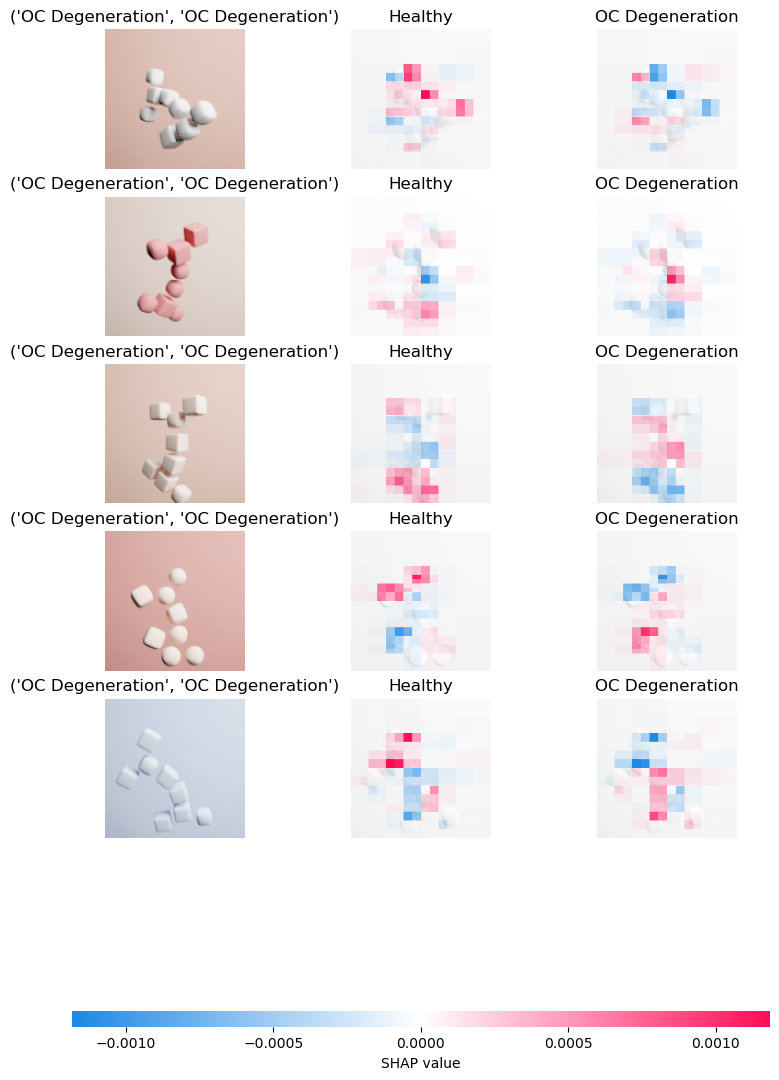

In [58]:
img_labels = [(CLASSES[int(t)], CLASSES[int(p)]) for t, p in zip(xai_corr_samples_df['ill'], xai_corr_samples_df['nobias_pred'])]
shap.image_plot(shap_values_corr, xai_corr_sample_images, labels=np.repeat([CLASSES], len(xai_corr_sample_images), axis=0), true_labels=img_labels, show=False)

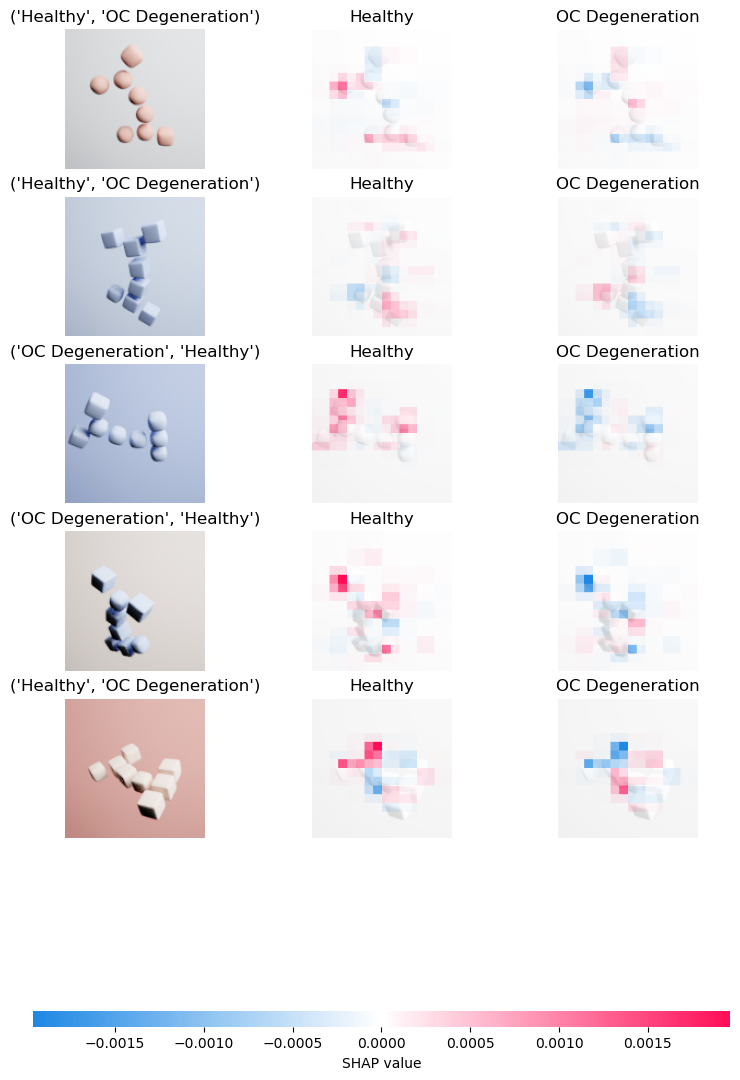

In [42]:
img_labels = [(CLASSES[int(t)], CLASSES[int(p)]) for t, p in zip(xai_inc_samples_df['ill'], xai_inc_samples_df['nobias_pred'])]
shap.image_plot(shap_values_inc, xai_inc_sample_images, labels=np.repeat([CLASSES], len(xai_inc_sample_images), axis=0), true_labels=img_labels, show=False)

array([[[0.83137255, 0.71372549, 0.67058824],
        [0.83921569, 0.72156863, 0.67843137],
        [0.83529412, 0.71764706, 0.6745098 ],
        ...,
        [0.89803922, 0.80392157, 0.76862745],
        [0.90196078, 0.80784314, 0.76862745],
        [0.89803922, 0.80392157, 0.76862745]],

       [[0.83137255, 0.71372549, 0.67058824],
        [0.83529412, 0.71372549, 0.67058824],
        [0.83529412, 0.71764706, 0.6745098 ],
        ...,
        [0.89803922, 0.80392157, 0.76862745],
        [0.89411765, 0.8       , 0.76470588],
        [0.89803922, 0.80392157, 0.76862745]],

       [[0.83137255, 0.71372549, 0.67058824],
        [0.83137255, 0.71372549, 0.67058824],
        [0.83529412, 0.71764706, 0.6745098 ],
        ...,
        [0.89803922, 0.80392157, 0.76470588],
        [0.89803922, 0.80392157, 0.76862745],
        [0.89411765, 0.8       , 0.76470588]],

       ...,

       [[0.76470588, 0.62745098, 0.58039216],
        [0.76078431, 0.62745098, 0.58039216],
        [0.76078431, 0

In [97]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def plot_shap_image(shap_values, img, pred, true, shap_idx=None):
  """
  Function to plot the SHAP values for one spectrogram and one prediction label.
  :param shap_values: array of shap values to plot
  :param spec: original spectrogram of audio file
  :param sr: sampling rate
  :param pred: prediction label
  :param true: ground truth label
  :param shap_idx: index of the prediction index to display shap values for.
         Leave as None to plot the shap values for the top prediction.
  """

  figsize = [9, 2.5]

  pred_idx = pred

  # Define colors for the SHAP-like colormap
  colors = []
  for j in np.linspace(1, 0, 100):
    colors.append((30./255, 136./255, 229./255,j))
  for j in np.linspace(0, 1, 100):
    colors.append((255./255, 13./255, 87./255,j))

  # Create the colormap
  shap_cmap = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

  # Setup figure
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

  #plot the spectrogram image
  image = np.squeeze(img)
  axes[0].imshow(image)
  # axes[0].set_title(f'Label: {CLASSES[true]} | Pred: {CLASSES[pred]}') 
  axes[0].set_title(f'Pred: {CLASSES[pred]}')


  # plot the shap values
  shap_idx = shap_idx if shap_idx is not None else pred_idx
  sv = np.mean(shap_values[:, :, :, pred_idx], axis=-1) # aggregate the channels
  lim = max(abs(sv.min()), abs(sv.max()))
  axes[1].imshow(image, alpha=0.50, cmap = 'Greys_r')
  im = axes[1].imshow(sv, vmin=-lim, vmax=lim, cmap = shap_cmap, alpha=0.75)
  # axes[1].set_title(f'Shap Values: {CLASSES[shap_idx]}')
  axes[1].set_title(f'Shap Values')
  axes[1].set_yticks([])
  axes[1].set_ylabel('')

  # setup colorbar
  width = 0.725
  left = (1 - width) / 2 + .01
  cax = fig.add_axes([left, -0.1, width, 0.03])  # [left, bottom, width, height]
  cb = fig.colorbar(im, cax=cax, label="Importance", orientation="horizontal",
                    aspect=figsize[0] / 0.2)
  cb.outline.set_visible(False)

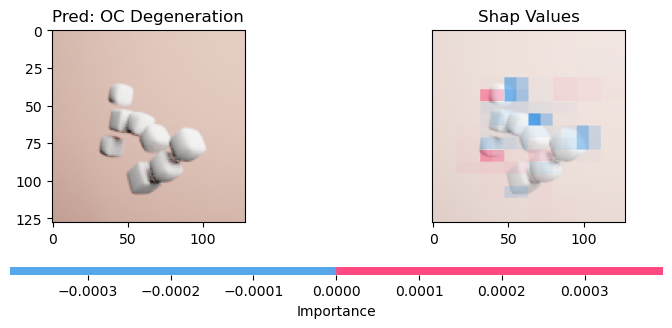

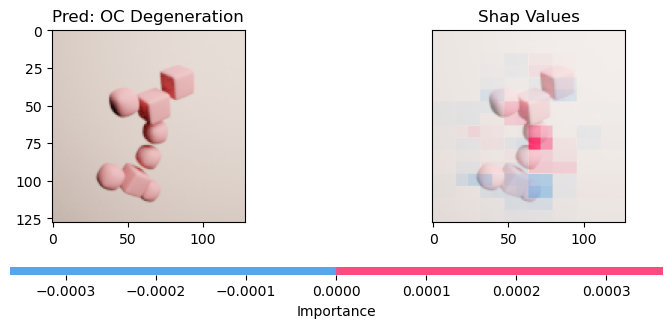

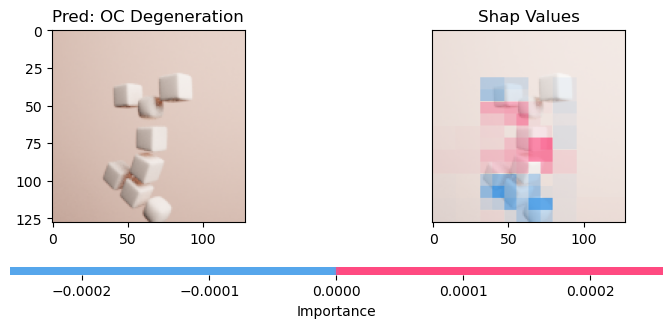

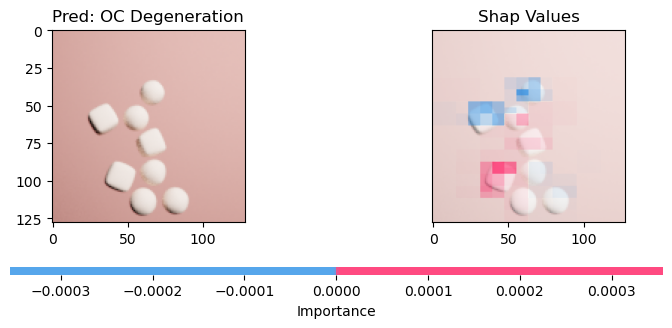

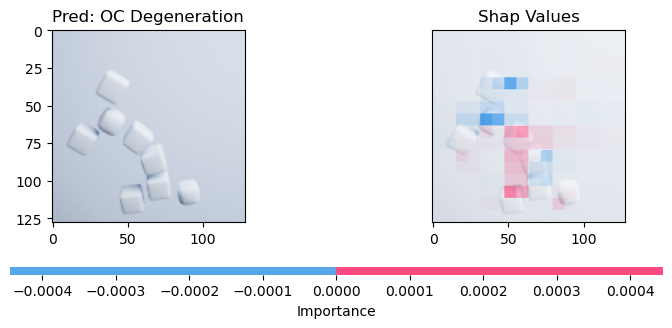

In [98]:
for i, (true, pred) in enumerate(zip(xai_corr_samples_df['ill'], xai_corr_samples_df['nobias_pred'])):
  plot_shap_image(shap_values_corr.values[i], xai_corr_sample_images[i], true, pred, shap_idx=None)
  plt.show()

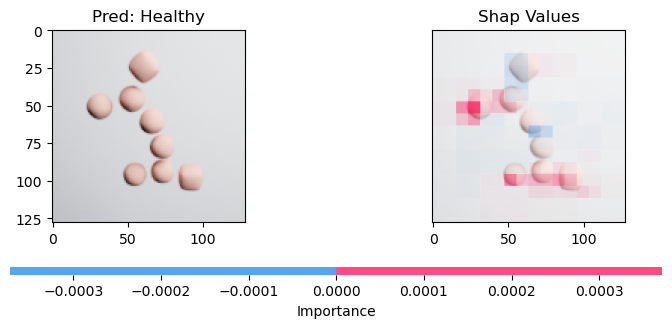

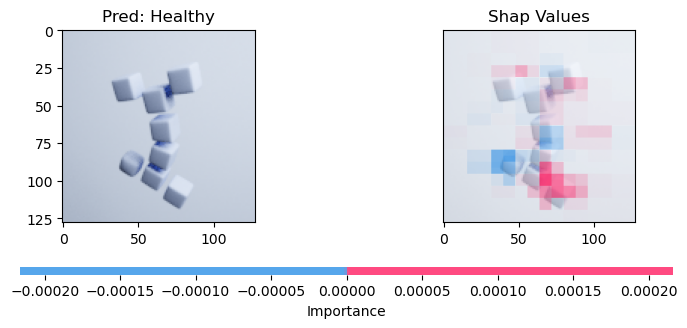

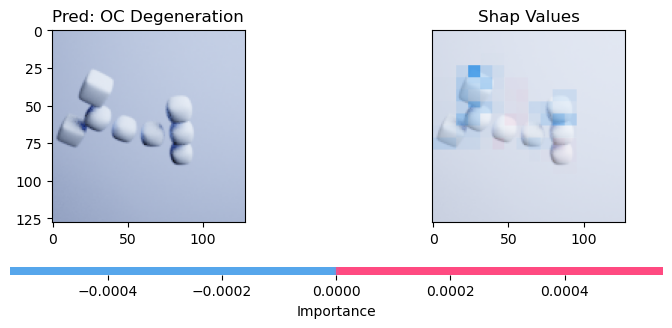

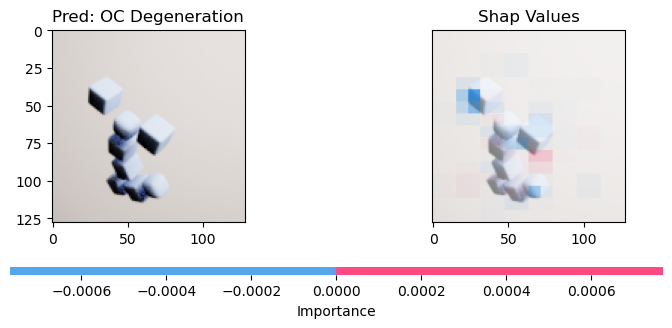

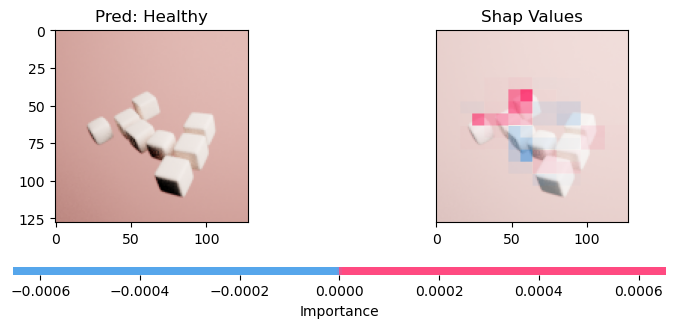

In [100]:
for i, (true, pred) in enumerate(zip(xai_inc_samples_df['ill'], xai_inc_samples_df['nobias_pred'])):
  plot_shap_image(shap_values_inc.values[i], xai_inc_sample_images[i], true, pred, shap_idx=None)
  plt.show()